**CHESS AI**

**Course:** Computer Vision & Image Analysis

**Project By:** Kogulan Natarajan

**Guided By:** Prof. Aurelien Quillet

In [19]:
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.models import model_from_json
import warnings
warnings.filterwarnings('ignore')

**Loading Data...**

In [2]:
train_size = 5000
test_size = 1500

train = glob.glob("../dataset/train/*.jpeg")
test = glob.glob("../dataset/test/*.jpeg")

shuffle(train)
shuffle(test)

train = train[:train_size]
test = test[:test_size]

piece_symbols = 'prbnkqPRBNKQ'

**Function to extract FEN from filename**

In [3]:
def fen_from_filename(filename):
  base = os.path.basename(filename)
  return os.path.splitext(base)[0]

**Examples:**

In [4]:
print(fen_from_filename(train[0]))
print(fen_from_filename(train[1]))
print(fen_from_filename(train[2]))

8-2k5-8-1K6-q7-1R6-1B2n3-8
n6R-2B1Rn2-K6q-4n1PP-3P4-8-1r4p1-1k6
2R1b3-8-5k2-5R2-1R4RP-8-3p4-4K2B


**Plotting samples**

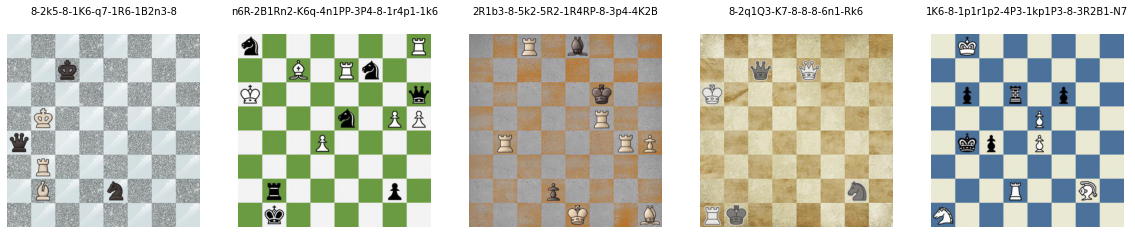

In [5]:
f, axarr = plt.subplots(1,5, figsize=(20, 30))

for i in range(0,5):
    axarr[i].set_title(fen_from_filename(train[i]), fontsize=10, pad=20)
    axarr[i].imshow(mpimg.imread(train[i]))
    axarr[i].axis('off')

**Functions to convert FEN to one-hot encoded vectors and vice-versa**

In [6]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

**Function to proccess an image:**\
    downsample an image to 200 by 200 pixel\
    split an image of the chess board to 64 images of individual squares\
    drop redundant dimensions, reshape\

In [7]:
def process_image(img):
    downsample_size = 200
    square_size = int(downsample_size/8)
    img_read = io.imread(img)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)

**Functions for sampling batches for training and evaluation:**

In [8]:
def train_gen(features, labels, batch_size):
    for i, img in enumerate(features):
        y = onehot_from_fen(fen_from_filename(img))
        x = process_image(img)
        yield x, y

def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_image(img)

**Define a model:**

In [9]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(25, 25, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(13))
model.add(Activation('softmax'))
model.compile(
  loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-01-31 13:18:07.377066: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Train the model:**

In [10]:
model.fit_generator(train_gen(train, None, 64), steps_per_epoch=train_size)

5000/5000 [==============================] - 354s 71ms/step - loss: 0.0427 - accuracy: 0.9890


**Testing the model:**

In [11]:
res = (
  model.predict_generator(pred_gen(test, 64), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

**Calculating an accuracy of the model:**

In [13]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([fen_from_filename(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.98933%


**Save Model**

In [16]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


**Load Model**

In [20]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


**Sample images and display predicted FEN**

In [14]:
def display_with_predicted_fen(image):
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()

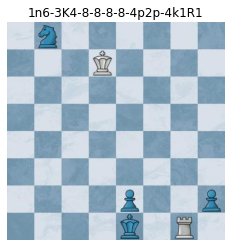

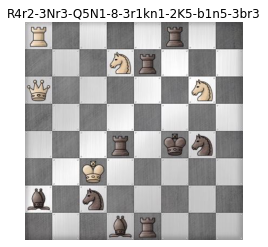

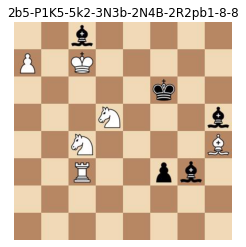

In [15]:
display_with_predicted_fen(test[0])
display_with_predicted_fen(test[1])
display_with_predicted_fen(test[2])

**Code Reference:**\
    1. https://www.kaggle.com/koryakinp/chess-fen-generator \
    2. https://www.kaggle.com/ashwinbhatt/improved-version-using-pytorch \
    3. https://www.kaggle.com/meditech101/chess-fen-generator-improved \
    4. https://www.youtube.com/watch?v=G5KFh9UZNfY&t=854s \
    5. https://www.kaggle.com/gcdatkin/chess-win-prediction-with-rnns
    

Thanks for the course